# This is a note to show the ratation diffusion and reverse process

### outline
random sample a point in SO3 manifold
run forward diffusion to gain the trajactory
covert the Ratation matrix to euler angle to show the diffusion process

Part II,
run reverse diffusion proces 
covert the Ratation matrix to euler angle to show the reverse diffusion process


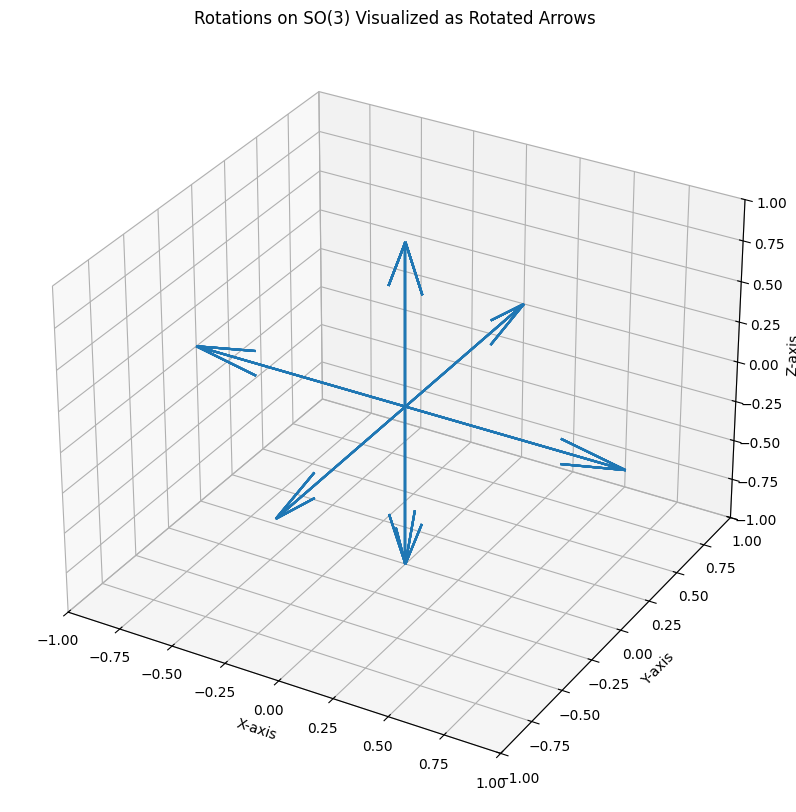

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

def generate_so3_grid(n):
    """
    Generate a grid on SO(3) using discretized Euler angles.
    
    Args:
        n (int): Number of samples along each Euler angle dimension.
    
    Returns:
        rotations (list of np.ndarray): List of rotation matrices.
    """
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    grids = [(a1, a2, a3) for a1 in angles for a2 in angles for a3 in angles]
    rotations = [R.from_euler('zyz', g).as_matrix() for g in grids]
    return rotations

def plot_rotations(rotations, arrow_length=1.0):
    """
    Visualize rotations on SO(3) by applying them to a 3D arrow.
    
    Args:
        rotations (list of np.ndarray): List of rotation matrices.
        arrow_length (float): Length of the arrows to plot.
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Define the arrow: starts at origin, points along z-axis
    arrow = np.array([[0, 0, 0], [0, 0, arrow_length]])
    
    # Plot each rotation
    for R in rotations:
        rotated_arrow = arrow @ R.T
        ax.quiver(
            rotated_arrow[0, 0], rotated_arrow[0, 1], rotated_arrow[0, 2],
            rotated_arrow[1, 0] - rotated_arrow[0, 0],
            rotated_arrow[1, 1] - rotated_arrow[0, 1],
            rotated_arrow[1, 2] - rotated_arrow[0, 2],
            length=arrow_length,
            normalize=True,
        )
    
    # Set the axes limits and labels
    ax.set_xlim([-arrow_length, arrow_length])
    ax.set_ylim([-arrow_length, arrow_length])
    ax.set_zlim([-arrow_length, arrow_length])
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title('Rotations on SO(3) Visualized as Rotated Arrows')
    plt.show()

# Example usage
rotations = generate_so3_grid(4)  # Adjust grid density
plot_rotations(rotations)


In [17]:
# sample one rotation
def sample_rotation(num_samples=1,random_state=None):
    """
    Sample a random rotation matrix from SO(3).
    
    Returns:
        rotation (np.ndarray): A random rotation matrix.
    """
    r = R.random(num=num_samples,random_state=random_state)
    return r.as_matrix()

# Example usage of sampling a random rotation
r_truth = sample_rotation(random_state=42) # use it as the ground truth
euler_truth = R.from_matrix(r_truth[0]).as_euler('zyz') # get the first rotation matrix
vector_truth = R.from_matrix(r_truth).as_rotvec() # get the rotation matrix from the euler angles
print(vector_truth.shape)


(1, 3)


In [4]:
import sys
sys.path.append('/home/yunyao/RFdiffusion/rfdiffusion')

#from util import rigid_from_3_points

In [5]:
# generate the diffusion process
from diffusion import IGSO3

T=200
min_sigma=0
max_sigma=1
min_b=0
max_b=1
cache_dir='./cache'

# rotation noise linear schedulear sigma(t) = sigma_min + (t/T)*beta_min + 1/2(t/T)^2(beta_max-beta_min)
# sigma_min = 0.02, beta_min =1.06  beta_max=1.77
# rotation noise log schedular  log(sigma(t))= logsigma_min + t/T * (log(sigma_max)-log(sigma_min))

# in the SI, it seems the linear one is used and max_sigma is not used
r_test = IGSO3(T=T,
        min_sigma=0.02,
        max_sigma=1,
        min_b=1.06,
        max_b=1.77,
        cache_dir=cache_dir,
        num_omega=1000,
        schedule="linear",
        L=2000)

In [6]:
from abc import ABC, abstractmethod
from typing import Optional
import math
import torch
class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor):
        """
        Takes one simulation step
        Args:
            - xt: state at time t, shape (batch_size, dim)
            - t: time, shape ()
            - dt: time, shape ()
        Returns:
            - nxt: state at time t + dt
        """
        pass

    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (batch_size, dim)
            - ts: timesteps, shape (nts,)
        Returns:
            - x_final: final state at time ts[-1], shape (batch_size, dim)
        """
        for t_idx in range(len(ts) - 1):
            t = ts[t_idx]
            h = ts[t_idx + 1] - ts[t_idx]
            x = self.step(x, t, h)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (bs, dim)
            - ts: timesteps, shape (num_timesteps,)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, num_timesteps, dim)
        """
        xs = [x.clone()]
        for t_idx in tqdm(range(len(ts) - 1)):
            t = ts[t_idx]
            h = ts[t_idx + 1] - ts[t_idx]
            x = self.step(x, t, h)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)

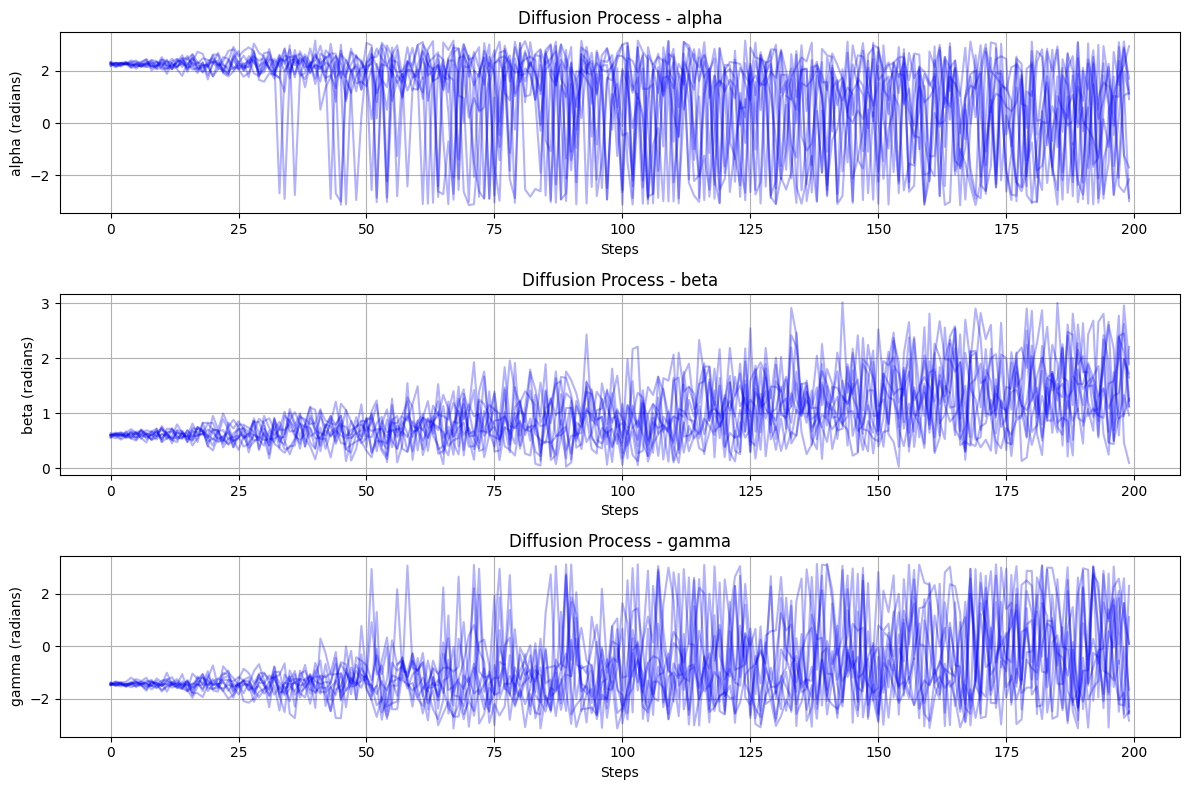

In [37]:
# forword diffusion process
# use r_test.sample: sample a angle from IGSO3 distribution at time t
# use r_test.sample_vec: sample a random axis and combine with the angle to genereate a rotation matrix at time t
t = np.arange(r_test.T) + 1 # [1, 2, ..., T]
n_samples = 10
sampled_rots = r_test.sample_vec( ts=t,n_samples=n_samples) # generate 30 trajactory
# convert it to eular angle
from scipy.spatial.transform import Rotation as scipy_R
R_sampled = (
            scipy_R.from_rotvec(sampled_rots.reshape(-1, 3))
            .as_matrix()
            .reshape(r_test.T, n_samples, 3, 3)
        ) # [step, traj, 3, 3]
R_perturbed = np.einsum("tnij,njk->tnik", R_sampled, r_truth)

# convert matrix to eular angle
Euler_perturbed = scipy_R.from_matrix(R_perturbed.reshape(-1,3,3)).as_euler('zyz').reshape(r_test.T, n_samples, 3) # [step, traj, 3]

def plot_angle_diffusion(data, angle_names=['alpha', 'beta', 'gamma']):
    steps, num_samples, num_angles = data.shape
    time = np.arange(steps)

    plt.figure(figsize=(12, 8))
    for i in range(num_angles):
        plt.subplot(3, 1, i + 1)
        # Plot all samples for the current angle
        for sample in range(num_samples):
            plt.plot(time, data[:, sample, i], alpha=0.3, color='blue')
        plt.title(f"Diffusion Process - {angle_names[i]}")
        plt.xlabel("Steps")
        plt.ylabel(f"{angle_names[i]} (radians)")
        plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function
plot_angle_diffusion(Euler_perturbed, angle_names=['alpha', 'beta', 'gamma'])

# now visualize the perturbed rotation


(200, 10, 3, 3)
(1, 3)
(3,)


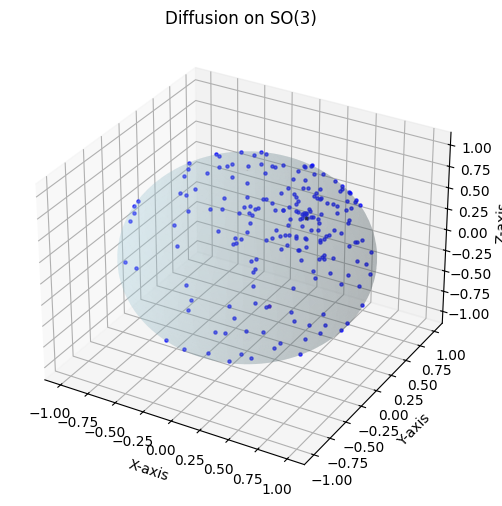

In [42]:
# forword diffusion process
# use r_test.sample: sample a angle from IGSO3 distribution at time t
# use r_test.sample_vec: sample a random axis and combine with the angle to genereate a rotation matrix at time t
t = np.arange(r_test.T) + 1 # [1, 2, ..., T]
n_samples = 10
sampled_rots = r_test.sample_vec( ts=t,n_samples=n_samples) # generate 30 trajactory
# convert it to eular angle
from scipy.spatial.transform import Rotation as scipy_R
R_sampled = (
            scipy_R.from_rotvec(sampled_rots.reshape(-1, 3))
            .as_matrix()
            .reshape(r_test.T, n_samples, 3, 3)
        ) # [step, traj, 3, 3]
R_perturbed = np.einsum("tnij,njk->tnik", R_sampled, r_truth)

print(R_perturbed.shape)
# convert matrix to eular angle

Vector_perturbed = scipy_R.from_matrix(R_perturbed.reshape(-1,3,3)).as_rotvec().reshape(r_test.T, n_samples, 3) # [step, traj, 3]
# normalize the rotation vectors
Vector_perturbed = Vector_perturbed / np.linalg.norm(Vector_perturbed, axis=2, keepdims=True)
def visualize_geodesic_path_on_so3(path, r1, r2=None):
    """Visualize the geodesic path on SO(3)."""
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')


    # Convert tensors to numpy arrays for plotting
    r1_np = r1.numpy()
    r2_np = r2.numpy()

    # covert matrix to rotation vector
    r1_np = scipy_R.from_matrix(r1_np).as_rotvec()
    r2_np = scipy_R.from_matrix(r2_np).as_rotvec()
    # Normalize the rotation vectors    
    r1_np = r1_np / np.linalg.norm(r1_np, axis=1, keepdims=True)
    r2_np = r2_np / np.linalg.norm(r2_np, axis=1, keepdims=True)




    # Plot the projected points
    ax.scatter(r1_np[:, 0], r1_np[:, 1], r1_np[:, 2], s=5, alpha=0.7,c='k',marker='*')
    ax.scatter(r2_np[:, 0], r2_np[:, 1], r2_np[:, 2], s=5, alpha=0.7,c='r',marker='*')

    # Plot the sphere
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color="lightblue", alpha=0.2)
    

    
    # Extract the rotation matrices
    for rotation in path:
        ax.scatter(rotation[:,0], rotation[:, 1], rotation[:,2], s=5, alpha=0.7,c='b',marker='o')
    
    # Label the axes
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title('Diffusion on SO(3)')
    
    # Show the plot
    plt.show()
print(vector_truth.shape)
print(Vector_perturbed[-1,0,:].shape)
#print(Vector_perturbed[:,0,:].unsqueeze(-2).shape)
visualize_geodesic_path_on_so3(torch.tensor(Vector_perturbed[:,0,:]).unsqueeze(1), torch.tensor(r_truth),torch.tensor(R_perturbed[-1,0,:]).unsqueeze(0)) # [step, traj, 3, 3]

## Part II. reverse diffusion

In [33]:
R_perturbed.shape
R_perturbed[0,...].shape

#Euler_perturbed[199,:,0]

(10, 3, 3)

In [34]:
# reverse diffusion process
from scipy.spatial.transform import Rotation as scipy_R
from tqdm import tqdm
import torch
class EulerMaruyama(Simulator):
    def __init__(self, diffuser):
        """
        Args:
            - beta_schedule: beta schedule, shape (num_timesteps,)
            - sigma_schedule: sigma schedule, shape (num_timesteps,)
            - noise_type: type of noise to add, either "linear" or "log"
        """
        super().__init__()
        self.diffuser = diffuser

    def step(self, rt: torch.Tensor, r0:torch.tensor, ts: torch.Tensor, ):
        """
        Takes one simulation step
        Args:
            - rt: state at time t, shape ( num_residues, 3, 3)
            - ts: time , shape () [1,...,T]
            - x0: the truth structure, shape (batch_size, num_residues, 3, 3)
        Returns:
            - nxt: reverse to xt-1
        """
        r_t_minus_1 = self.diffuser.reverse_sample_vectorized(rt, r0, ts, noise_level=0.5)

        return r_t_minus_1


    
    def simulate_with_trajectory(self, rt: torch.Tensor, r0: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (bs, dim)
            - ts: timesteps, shape (num_timesteps,)
            - x0: the truth structure, shape (batch_size, num_residues, 3, 3)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, num_timesteps, dim)
        """
        rs = [rt.clone()]
        for t_idx in tqdm(range(len(ts) - 1)):
            t = ts[t_idx]
            rt = self.step(rt, r0, t)
            rs.append(rt.clone())
        return torch.stack(rs, dim=1)

In [35]:
t = np.arange(r_test.T) + 1 # [1, 2, ..., T]
t_reversed = t[::-1]
reversed_rotations = EulerMaruyama(r_test).simulate_with_trajectory(
    torch.tensor(R_perturbed[199,...].reshape(-1, 3, 3), dtype=torch.float64),  # Ensure Double type
    torch.tensor(r_truth, dtype=torch.float64),  # Ensure Double type
    t_reversed,
).reshape(r_test.T, n_samples, 3, 3)  # [step, traj, 3, 3]


  0%|          | 0/199 [00:00<?, ?it/s]/home/yunyao/RFdiffusion/rfdiffusion/diffusion.py:497: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R_0, R_t = torch.tensor(R_0), torch.tensor(R_t)
100%|██████████| 199/199 [00:00<00:00, 1917.79it/s]


(200, 10, 3)


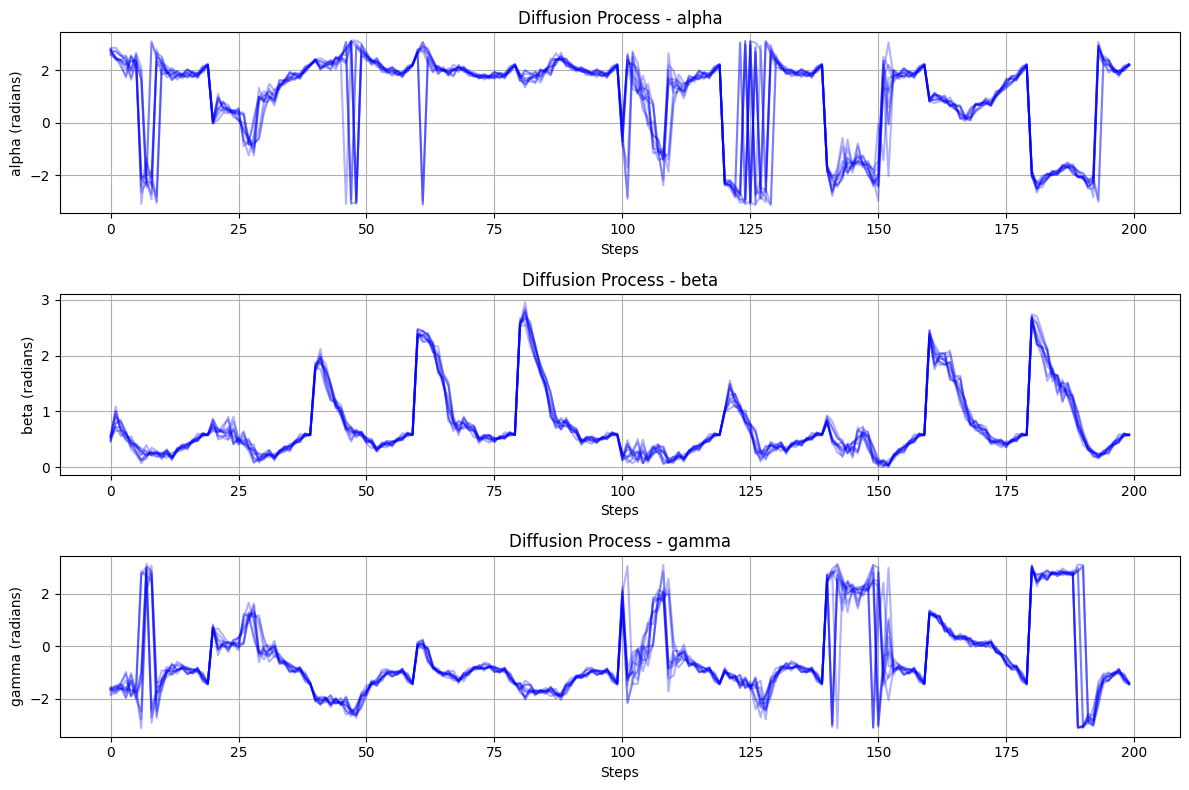

In [38]:
# convert matrix to eular angle
Euler_reversed = scipy_R.from_matrix(reversed_rotations.reshape(-1,3,3)).as_euler('zyz').reshape(r_test.T, n_samples, 3) # [step, traj, 3]
print(Euler_reversed.shape)
# plot the reversed trajectory
plot_angle_diffusion(Euler_reversed, angle_names=['alpha', 'beta', 'gamma'])

/tmp/ipykernel_1933221/1341953493.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  visualize_geodesic_path_on_so3(torch.tensor(Vector_reversed[:,0,:]).unsqueeze(1), torch.tensor(r_truth),torch.tensor(reversed_rotations[-1,0,:]).unsqueeze(0)) # [step, traj, 3, 3]


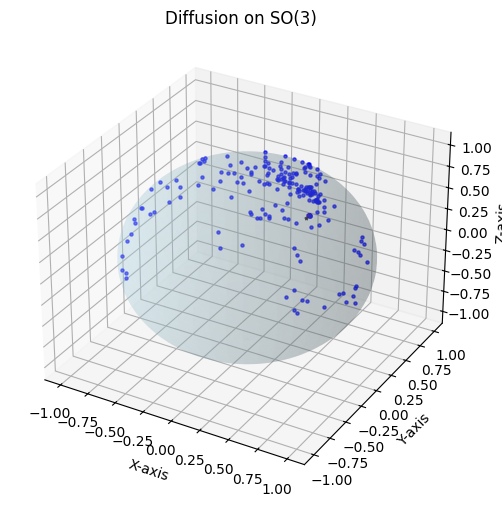

In [43]:
# plot the revesred trajectory on SO3
Vector_reversed = scipy_R.from_matrix(reversed_rotations.reshape(-1,3,3)).as_rotvec().reshape(r_test.T, n_samples, 3) # [step, traj, 3]
# normalize the rotation vectors
Vector_reversed = Vector_reversed / np.linalg.norm(Vector_reversed, axis=2, keepdims=True)
visualize_geodesic_path_on_so3(torch.tensor(Vector_reversed[:,0,:]).unsqueeze(1), torch.tensor(r_truth),torch.tensor(reversed_rotations[-1,0,:]).unsqueeze(0)) # [step, traj, 3, 3]

In [45]:
def visualize_geodesic_path_on_so3_II(path, r1, r2=None):
    """Visualize the geodesic path on SO(3)."""
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Convert tensors to numpy arrays for plotting
    r1_np = r1.numpy()
    r2_np = r2.numpy()

    # Convert matrix to rotation vector
    r1_np = scipy_R.from_matrix(r1_np).as_rotvec()
    r2_np = scipy_R.from_matrix(r2_np).as_rotvec()

    # Normalize the rotation vectors    
    r1_np = r1_np / np.linalg.norm(r1_np, axis=1, keepdims=True)
    r2_np = r2_np / np.linalg.norm(r2_np, axis=1, keepdims=True)

    # Plot the initial and final points
    ax.scatter(r1_np[:, 0], r1_np[:, 1], r1_np[:, 2], s=50, alpha=0.7, c='k', marker='*', label='Start Points')
    ax.scatter(r2_np[:, 0], r2_np[:, 1], r2_np[:, 2], s=50, alpha=0.7, c='r', marker='*', label='End Points')

    # Plot the sphere
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color="lightblue", alpha=0.2)

    # Plot the geodesic path with connecting lines
    path_np = [scipy_R.from_matrix(rotation).as_rotvec() for rotation in path]
    path_np = np.array(path_np)
    path_np = path_np / np.linalg.norm(path_np, axis=2, keepdims=True)

    # Scatter points on the path
    ax.scatter(path_np[:, 0], path_np[:, 1], path_np[:, 2], s=20, alpha=0.7, c='b', marker='o', label='Path Points')

    # Plot connecting lines
    for i in range(len(path_np) - 1):
        ax.plot(
            [path_np[i, 0], path_np[i + 1, 0]],
            [path_np[i, 1], path_np[i + 1, 1]],
            [path_np[i, 2], path_np[i + 1, 2]],
            c='b', alpha=0.5, linestyle='-'
        )

    # Label the axes
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title('Geodesic Path on SO(3)')
    ax.legend()

    # Show the plot
    plt.show()


/tmp/ipykernel_1933221/939757390.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  visualize_geodesic_path_on_so3(torch.tensor(reversed_rotations[:,0,:]).unsqueeze(1), torch.tensor(r_truth),torch.tensor(reversed_rotations[-1,0,:]).unsqueeze(0)) # [step, traj, 3, 3]


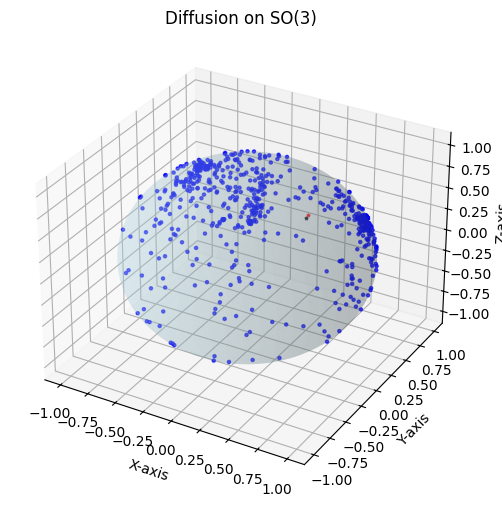

In [46]:
visualize_geodesic_path_on_so3(torch.tensor(reversed_rotations[:,0,:]).unsqueeze(1), torch.tensor(r_truth),torch.tensor(reversed_rotations[-1,0,:]).unsqueeze(0)) # [step, traj, 3, 3]

# Issue:

I am concerned about the narrow distribution of the 10 sample points. I am wondering if something is wrong.

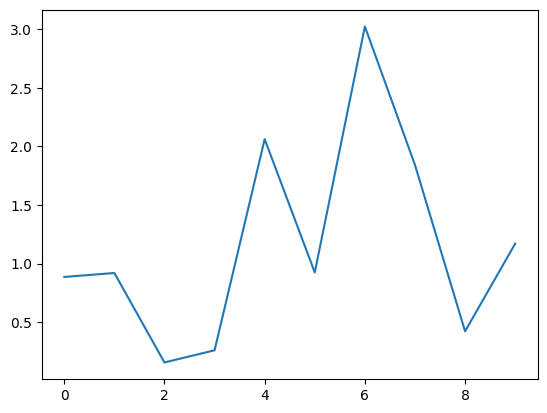

In [63]:
# troubleshooting
plt.plot(Euler_perturbed[199,:,1], label='perturbed')

## test with random angle distribution

In [57]:
R_test=sample_rotation(num_samples=10,random_state=0)

In [58]:
t = np.arange(r_test.T) + 1 # [1, 2, ..., T]
t_reversed = t[::-1]
reversed_rotations = EulerMaruyama(r_test).simulate_with_trajectory(
    torch.tensor(R_test.reshape(-1, 3, 3), dtype=torch.float64),  # Ensure Double type
    torch.tensor(r_truth, dtype=torch.float64),  # Ensure Double type
    t_reversed,
).reshape(r_test.T, n_samples, 3, 3)  # [step, traj, 3, 3]

  0%|          | 0/199 [00:00<?, ?it/s]/home/yunyao/RFdiffusion/rfdiffusion/diffusion.py:497: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R_0, R_t = torch.tensor(R_0), torch.tensor(R_t)
100%|██████████| 199/199 [00:00<00:00, 2531.49it/s]


(200, 10, 3)


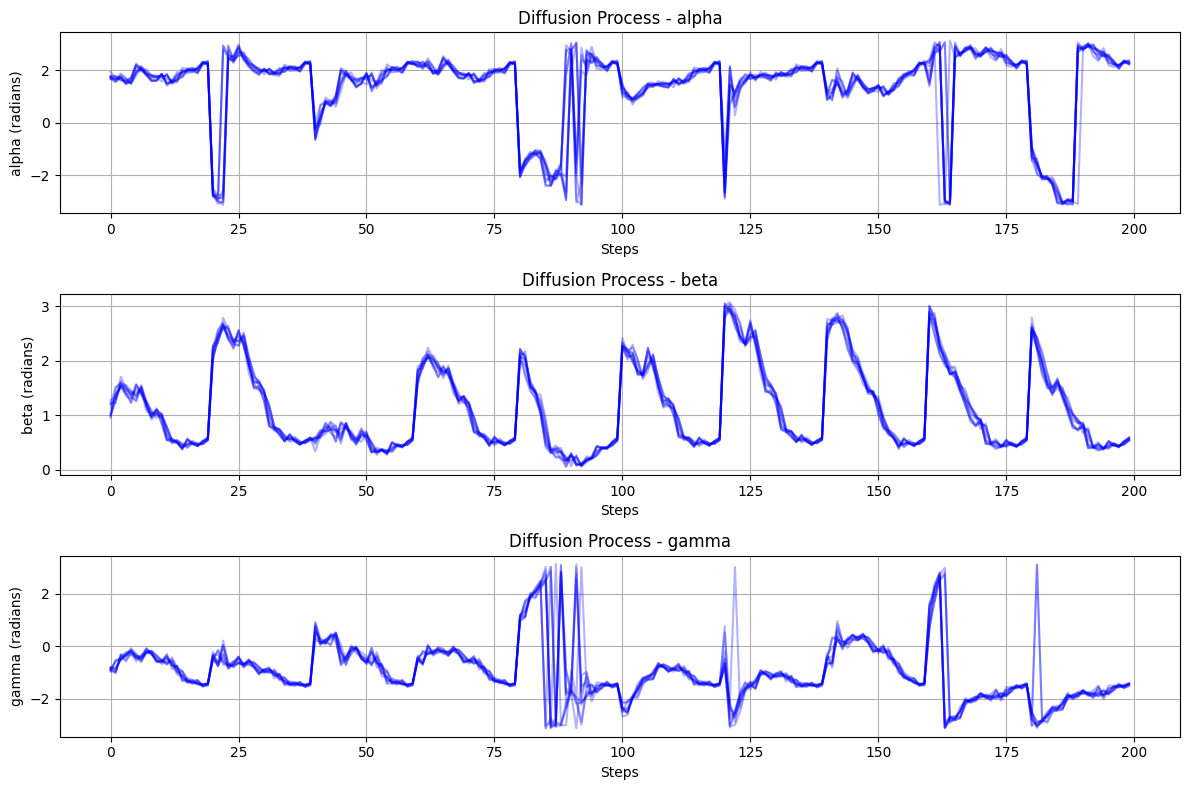

In [59]:
# convert matrix to eular angle
Euler_reversed = scipy_R.from_matrix(reversed_rotations.reshape(-1,3,3)).as_euler('zyz').reshape(r_test.T, n_samples, 3) # [step, traj, 3]
print(Euler_reversed.shape)
# plot the reversed trajectory
plot_angle_diffusion(Euler_reversed, angle_names=['alpha', 'beta', 'gamma'])